This is the third notebook working on Multi-Task Learning. In this notebook MSLE loss function is tried out with a combination of ReLU, Leaky ReLU, and PReLU activation functions. Additionally, this notebook drops the ReLU output tests and instead focuses on testing two optimizers: Adam and Adadelta.

* Optimizer: Adam + Adadelta
* Loss: MSLE
* Epochs: 250
* Batch-size: 64

In [1]:
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, advanced_activations, BatchNormalization, LeakyReLU, PReLU
from keras import losses, optimizers, activations
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

from scipy import stats
import time
import datetime
import os

C:\Users\drllc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Pre-Processed Data

In [2]:
data_scaled_shuffled = pd.read_csv('Dataset_Scaled_Shuffled.csv')
print('Shuffled dataset loaded.')

Shuffled dataset loaded.


## Prepare Data for Neural Nets

In [3]:
# Get number of data points
data_points = data_scaled_shuffled.shape[0]

# Set sizes for train, dev, test sets
train_percent = 0.8
train_size = round(train_percent*data_points)

if (data_points-train_size)%2 == 0:
    dev_size = int((data_points-train_size)/2)
    test_size = dev_size
    print('Train Size = {}'.format(train_size))
    print('Dev Size = {}'.format(dev_size))
    print('Test Size = {}'.format(test_size))
    print('Remainder = {}'.format(train_size+dev_size+test_size-data_points))
    
else:
    train_size = train_size-1
    dev_size = int((data_points-train_size)/2)
    test_size = dev_size 
    print('Train Size = {}'.format(train_size))
    print('Dev Size = {}'.format(dev_size))
    print('Test Size = {}'.format(test_size))
    print('Remainder = {}'.format(train_size+dev_size+test_size-data_points))

Train Size = 62511
Dev Size = 7814
Test Size = 7814
Remainder = 0


In [4]:
# Divide data into train, dev, and test sets
train_set = data_scaled_shuffled[:train_size]
dev_set = data_scaled_shuffled[train_size:train_size+dev_size]
test_set = data_scaled_shuffled[train_size+dev_size:train_size+dev_size+test_size]

# Reset index for all sets
train_set = train_set.reset_index(drop=True)
dev_set = dev_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

# Get values
train_set_values = train_set.values
dev_set_values = dev_set.values
test_set_values = test_set.values

# Number of emissions: HC, CO, CO2, NOX
n_out = 4

# SLICING: [start row:end row , start column:end column]
# Split into inputs and outputs
x_train = train_set_values[:,:-n_out]
x_dev = dev_set_values[:,:-n_out]
x_test = test_set_values[:,:-n_out]

#MPG_train = train_set_values[:,-6]
HC_train = train_set_values[:,-n_out]
CO_train = train_set_values[:,-n_out+1]
CO2_train = train_set_values[:,-n_out+2]
NOX_train = train_set_values[:,-n_out+3]
#PM_train = train_set_values[:,-1]

y_train = [HC_train, CO_train, CO2_train, NOX_train]

#MPG_dev = dev_set_values[:,-6]
HC_dev = dev_set_values[:,-n_out]
CO_dev = dev_set_values[:,-n_out+1]
CO2_dev = dev_set_values[:,-n_out+2]
NOX_dev = dev_set_values[:,-n_out+3]
#PM_dev = dev_set_values[:,-1]

y_dev = [HC_dev, CO_dev, CO2_dev, NOX_dev]

#MPG_test = test_set_values[:,-6]
HC_test = test_set_values[:,-n_out]
CO_test = test_set_values[:,-n_out+1]
CO2_test = test_set_values[:,-n_out+2]
NOX_test = test_set_values[:,-n_out+3]
#PM_test = test_set_values[:,-1]

y_test = [HC_test, CO_test, CO2_test, NOX_test]

------------------
# NEURAL NETWORKS

In [7]:
# Metrics
test_metrics = {'HC': 'accuracy',
               'CO': 'accuracy','CO2': 'accuracy',
               'NOX': 'accuracy'}

# Losses
main_func = losses.mean_squared_logarithmic_error
loss_list = [main_func,main_func,main_func,main_func]

# Dropout rate
dd = 0.05

In [8]:
# Mini-batch size  & epochs
batch_size = 64
epochs = 250

## Neural Networks:

### Version 2.0
* Activation Function = ReLU
* Output Activation Function = Linear
* Optimizer = ADAM

### Version 2.1 - Linear:
* Activation Function = ReLU
* Output Activation Function = Linear
* Optimizer = Adadelta

### Version 3.0:
* Activation Function = Leaky ReLU
* Output Activation Function = Linear
* Optimizer = ADAM

### Version 3.1 - Linear:
* Activation Function = Leaky ReLU
* Output Activation Function = Linear
* Optimizer = Adadelta

### Version 4.0:
* Activation Function = PReLU
* Output Activation Function = Linear
* Optimizer = ADAM

### Version 4.1:
* Activation Function = PReLU
* Output Activation Function = Linear
* Optimizer = Adadelta

In [9]:
# Function to create each model based on the version specified
def create_model(version):
    
    # Version 2.0 - ReLU & Adam
    if version == 2.0:

        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)
        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32, activation='relu')(x)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16, activation='relu')(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32, activation='relu')(x)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16, activation='relu')(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32, activation='relu')(x)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16, activation='relu')(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32, activation='relu')(x)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16, activation='relu')(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)

        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adam', metrics=test_metrics)
        model.summary()
        
    # Version 2.1 - ReLU & Adadelta
    if version == 2.1:

        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)
        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32, activation='relu')(x)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16, activation='relu')(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32, activation='relu')(x)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16, activation='relu')(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32, activation='relu')(x)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16, activation='relu')(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32, activation='relu')(x)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16, activation='relu')(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adadelta', metrics=test_metrics)
        model.summary()
        
    # Version 3.0 - Leaky ReLU & Adam
    if version == 3.0:

        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256)(inputs)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(128)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(64)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32)(x)
        HC_layer = LeakyReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16)(HC_layer)
        HC_layer = LeakyReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32)(x)
        CO_layer = LeakyReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16)(CO_layer)
        CO_layer = LeakyReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32)(x)
        CO2_layer = LeakyReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16)(CO2_layer)
        CO2_layer = LeakyReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32)(x)
        NOX_layer = LeakyReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16)(NOX_layer)
        NOX_layer = LeakyReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adam', metrics=test_metrics)
        model.summary()
        
    # Version 3.1 - Leaky ReLU & Adadelta
    if version == 3.1:

        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256)(inputs)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(128)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(64)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32)(x)
        HC_layer = LeakyReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16)(HC_layer)
        HC_layer = LeakyReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32)(x)
        CO_layer = LeakyReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16)(CO_layer)
        CO_layer = LeakyReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32)(x)
        CO2_layer = LeakyReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16)(CO2_layer)
        CO2_layer = LeakyReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32)(x)
        NOX_layer = LeakyReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16)(NOX_layer)
        NOX_layer = LeakyReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adadelta', metrics=test_metrics)
        model.summary()
        
    # Version 4.0 - PReLU & Adam
    if version == 4.0:
        
        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256)(inputs)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(128)(x)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(64)(x)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32)(x)
        HC_layer = PReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16)(HC_layer)
        HC_layer = PReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32)(x)
        CO_layer = PReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16)(CO_layer)
        CO_layer = PReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32)(x)
        CO2_layer = PReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16)(CO2_layer)
        CO2_layer = PReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32)(x)
        NOX_layer = PReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16)(NOX_layer)
        NOX_layer = PReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adam', metrics=test_metrics)
        model.summary()
        
    # Version 4.1 - PReLU & Adadelta
    if version == 4.1:
        
        # This returns a tensor
        inputs = Input(shape=(x_train.shape[1],))

        # a layer instance is callable on a tensor, and returns a tensor
        x = Dense(256)(inputs)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(128)(x)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        x = Dense(64)(x)
        x = PReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(dd)(x)

        HC_layer = Dense(32)(x)
        HC_layer = PReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)
        HC_layer = Dense(16)(HC_layer)
        HC_layer = PReLU()(HC_layer)
        #HC_layer = BatchNormalization()(HC_layer)
        HC_layer = Dropout(dd)(HC_layer)

        CO_layer = Dense(32)(x)
        CO_layer = PReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)
        CO_layer = Dense(16)(CO_layer)
        CO_layer = PReLU()(CO_layer)
        #CO_layer = BatchNormalization()(CO_layer)
        CO_layer = Dropout(dd)(CO_layer)

        CO2_layer = Dense(32)(x)
        CO2_layer = PReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)
        CO2_layer = Dense(16)(CO2_layer)
        CO2_layer = PReLU()(CO2_layer)
        #CO2_layer = BatchNormalization()(CO2_layer)
        CO2_layer = Dropout(dd)(CO2_layer)

        NOX_layer = Dense(32)(x)
        NOX_layer = PReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)
        NOX_layer = Dense(16)(NOX_layer)
        NOX_layer = PReLU()(NOX_layer)
        #NOX_layer = BatchNormalization()(NOX_layer)
        NOX_layer = Dropout(dd)(NOX_layer)


        #connect all the heads to their final output layers
        y1 = Dense(1, activation='linear',name= 'HC')(HC_layer)
        y2 = Dense(1, activation='linear',name= 'CO')(CO_layer)
        y3 = Dense(1, activation='linear',name= 'CO2')(CO2_layer)
        y4 = Dense(1, activation='linear',name= 'NOX')(NOX_layer)

        # This creates a model that includes inputs and all outputs
        model = Model(inputs=inputs, outputs=[y1, y2, y3, y4])

        model.compile(loss=loss_list, optimizer='adadelta', metrics=test_metrics)
        model.summary()
        
        
    return model

## Create Models

Only create models that have linear outputs.

In [10]:
model_v2_adam = create_model(2.0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256)          1024        dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (D

In [11]:
model_v2_adadelta = create_model(2.1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          4864        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 256)          1024        dense_12[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 256)          0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
dense_13 (

In [22]:
model_v3_adam = create_model(3.0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 256)          4864        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 256)          0           dense_34[0][0]                   
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 256)          1024        leaky_re_lu_12[0][0]             
__________________________________________________________________________________________________
dropout_34

In [23]:
model_v3_adadelta = create_model(3.1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 256)          4864        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 256)          0           dense_45[0][0]                   
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 256)          1024        leaky_re_lu_23[0][0]             
__________________________________________________________________________________________________
dropout_45

In [24]:
model_v4_adam = create_model(4.0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 256)          4864        input_6[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 256)          256         dense_56[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 256)          1024        p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
dropout_56

In [25]:
model_v4_adadelta = create_model(4.1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_67 (Dense)                (None, 256)          4864        input_7[0][0]                    
__________________________________________________________________________________________________
p_re_lu_12 (PReLU)              (None, 256)          256         dense_67[0][0]                   
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256)          1024        p_re_lu_12[0][0]                 
__________________________________________________________________________________________________
dropout_67

In [26]:
# Model Metrics
print('V2 = {}'.format(model_v2_adam.metrics_names))
print('V2.1 = {}'.format(model_v2_adadelta.metrics_names))
print('V3 = {}'.format(model_v3_adam.metrics_names))
print('V3.1 = {}'.format(model_v3_adadelta.metrics_names))
print('V4 = {}'.format(model_v4_adam.metrics_names))
print('V4.1 = {}'.format(model_v4_adadelta.metrics_names))

V2 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
V2.1 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
V3 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
V3.1 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
V4 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']
V4.1 = ['loss', 'HC_loss', 'CO_loss', 'CO2_loss', 'NOX_loss', 'HC_acc', 'CO_acc', 'CO2_acc', 'NOX_acc']


In [28]:
model_v2_adadelta.optimizer

## Training

In [29]:
# Function to call for training models based on the version
def train_model(version):
    
    if version == 2.0:
        model = model_v2_adam

    if version == 2.1:
        model = model_v2_adadelta
        
    if version == 3.0:
        model = model_v3_adam
        
    if version == 3.1:
        model = model_v3_adadelta
        
    if version == 4.0:
        model = model_v4_adam
        
    if version == 4.1:
        model = model_v4_adadelta
        
    # -------------------------------
    print('Model V{} Training Started'.format(version))
    print('Optimizer: {}'.format(model.optimizer))
    print(datetime.datetime.now())
    # Start timer
    start_time = time.time()

    # fit network
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(x_dev, y_dev), verbose=0, shuffle=True)

    # End timer
    end_time = time.time() - start_time
    print('Model V{} Training Complete'.format(version))
    print('Time: {:.3f} s'.format(end_time))
    print('Time: {:.3f} min'.format(end_time/60))
    print('----------------------------------')
        
    return history

In [30]:
history_v2_adam = train_model(2.0)
history_v2_adadelta = train_model(2.1)
history_v3_adam = train_model(3.0)
history_v3_adadelta = train_model(3.1)
history_v4_adam = train_model(4.0)
history_v4_adadelta = train_model(4.1)

Model V2.0 Training Started
Optimizer: <keras.optimizers.Adam object at 0x00000167C08D5080>
2019-03-14 06:51:49.547875
Model V2.0 Training Complete
Time: 2631.203 s
Time: 43.853 min
----------------------------------
Model V2.1 Training Started
Optimizer: <keras.optimizers.Adadelta object at 0x00000167C10AE2E8>
2019-03-14 07:35:40.750706
Model V2.1 Training Complete
Time: 2843.084 s
Time: 47.385 min
----------------------------------
Model V3.0 Training Started
Optimizer: <keras.optimizers.Adam object at 0x00000167C233E668>
2019-03-14 08:23:03.834773
Model V3.0 Training Complete
Time: 2774.930 s
Time: 46.249 min
----------------------------------
Model V3.1 Training Started
Optimizer: <keras.optimizers.Adadelta object at 0x00000167C2B7F4E0>
2019-03-14 09:09:18.764656
Model V3.1 Training Complete
Time: 3099.468 s
Time: 51.658 min
----------------------------------
Model V4.0 Training Started
Optimizer: <keras.optimizers.Adam object at 0x00000167C60E6BE0>
2019-03-14 10:00:58.232431
Model

In [31]:
print('V2 Size = {}'.format(np.size(history_v2_adam.history['loss'])))
print('V2.1 Size = {}'.format(np.size(history_v2_adadelta.history['loss'])))
print('V3 Size = {}'.format(np.size(history_v3_adam.history['loss'])))
print('V3.1 Size = {}'.format(np.size(history_v3_adadelta.history['loss'])))
print('V4 Size = {}'.format(np.size(history_v4_adam.history['loss'])))
print('V4.1 Size = {}'.format(np.size(history_v4_adadelta.history['loss'])))

V2 Size = 250
V2.1 Size = 250
V3 Size = 250
V3.1 Size = 250
V4 Size = 250
V4.1 Size = 250


## Graphing Losses

In [82]:
# Create epoch vector
epoch_vector = np.linspace(1,np.size(history_v2_adam.history['loss']),np.size(history_v2_adam.history['loss']))

# Function to graph general loss
def graph_general_loss(version, optimizer):
    
    if version == 2.0:
        history = history_v2_adam

    if version == 2.1:
        history = history_v2_adadelta
        
    if version == 3.0:
        history = history_v3_adam
        
    if version == 3.1:
        history = history_v3_adadelta
        
    if version == 4.0:
        history = history_v4_adam
        
    if version == 4.1:
        history = history_v4_adadelta
        
    # plot main loss
    plt.figure(figsize=(12,7))
    plt.plot(epoch_vector, history.history['loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_loss'], 'r', label='Validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim((0.005,0.04))
    plt.legend() 
    plt.grid()
    plt.savefig('Multi_Task_General_Loss-V{}-{}.png'.format(version, optimizer), dpi=200)

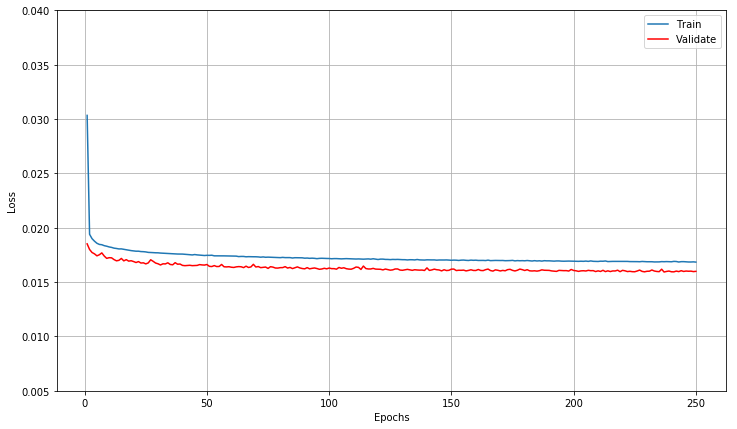

In [83]:
graph_general_loss(2.0, 'adam')

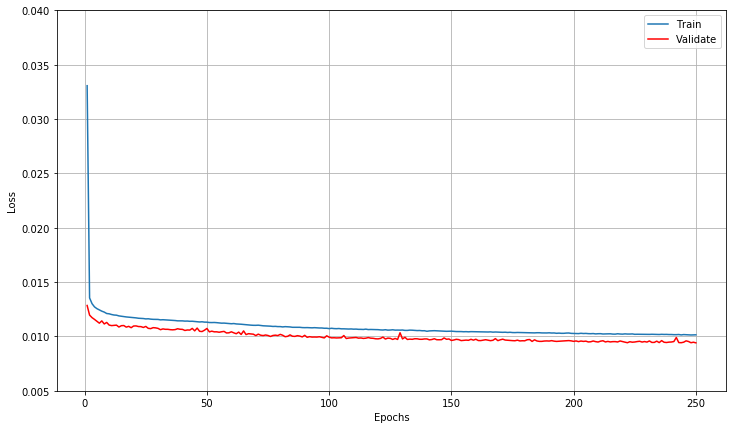

In [84]:
graph_general_loss(2.1, 'adadelta')

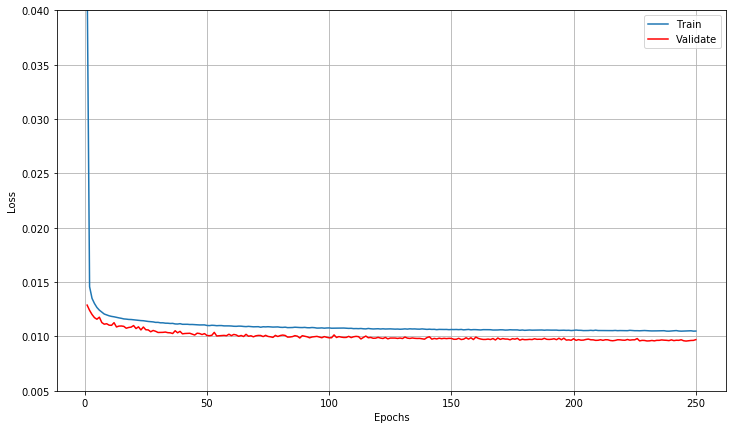

In [85]:
graph_general_loss(3.0, 'adam')

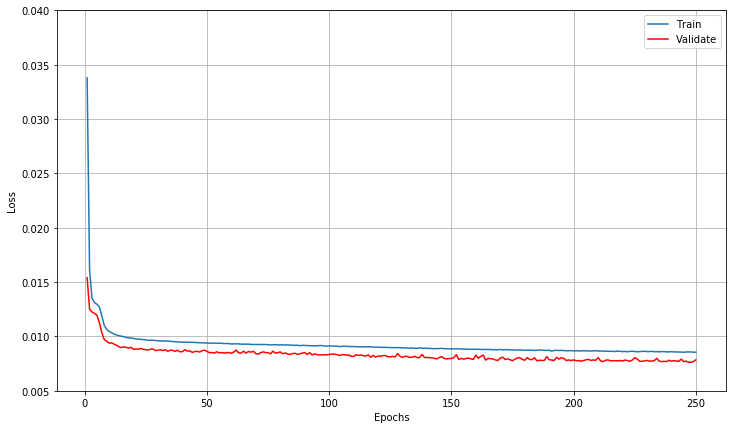

In [86]:
graph_general_loss(3.1, 'adadelta')

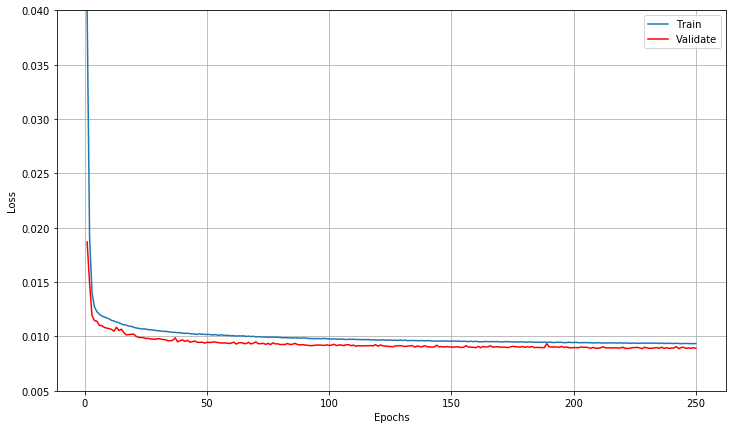

In [87]:
graph_general_loss(4.0, 'adam')

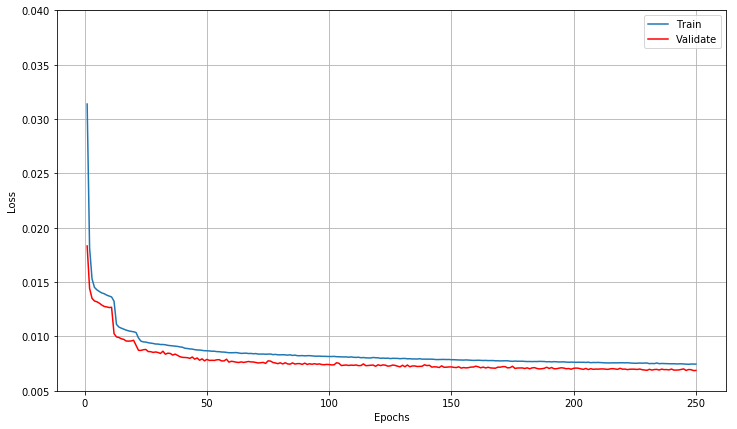

In [88]:
graph_general_loss(4.1, 'adadelta')

In [54]:
# Function to graph individual losses according to version
def graph_individual_losses(version, optimizer):
    
    if version == 2.0:
        history = history_v2_adam

    if version == 2.1:
        history = history_v2_adadelta
        
    if version == 3.0:
        history = history_v3_adam
        
    if version == 3.1:
        history = history_v3_adadelta
        
    if version == 4.0:
        history = history_v4_adam
        
    if version == 4.1:
        history = history_v4_adadelta
        
    #--------------------------------
    # Create plots
    
    plt.figure(figsize=(18,12)) 

    plt.subplot(2, 2, 1)
    plt.plot(epoch_vector, history.history['HC_loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_HC_loss'], 'r', label='Dev')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim((0.0018,0.0045))
    plt.title('HC Loss')
    plt.grid()
    plt.legend()   

    plt.subplot(2, 2, 2)
    plt.plot(epoch_vector, history.history['CO_loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_CO_loss'], 'r', label='Dev')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim((0.0009,0.004))
    plt.title('CO Loss')
    plt.grid()
    plt.legend()   

    plt.subplot(2, 2, 3)
    plt.plot(epoch_vector, history.history['CO2_loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_CO2_loss'], 'r', label='Dev')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim((0.005,0.015))
    plt.title('CO2 Loss')
    plt.grid()
    plt.legend()   

    plt.subplot(2, 2, 4)
    plt.plot(epoch_vector, history.history['NOX_loss'], label='Train')
    plt.plot(epoch_vector, history.history['val_NOX_loss'], 'r', label='Dev')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim((0.0014,0.0045))
    plt.title('NOX Loss')
    plt.grid()
    plt.legend()   

    plt.savefig('Multi_Task_Losses-V{}-{}.png'.format(version, optimizer), dpi=200)

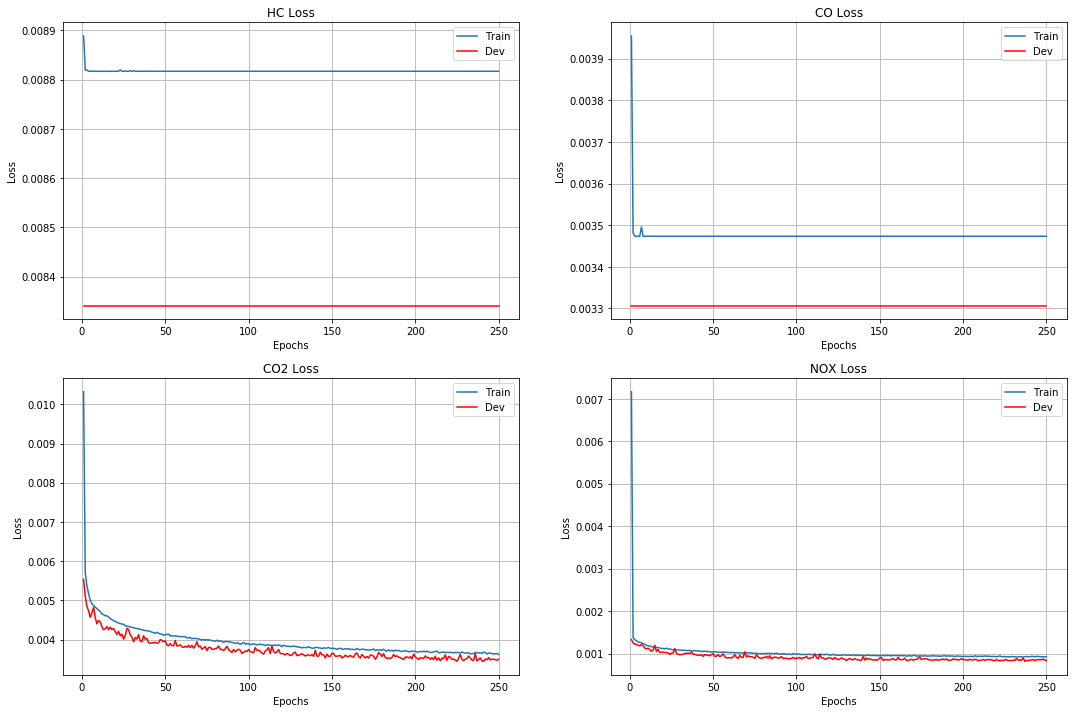

In [55]:
graph_individual_losses(2.0, 'adam')

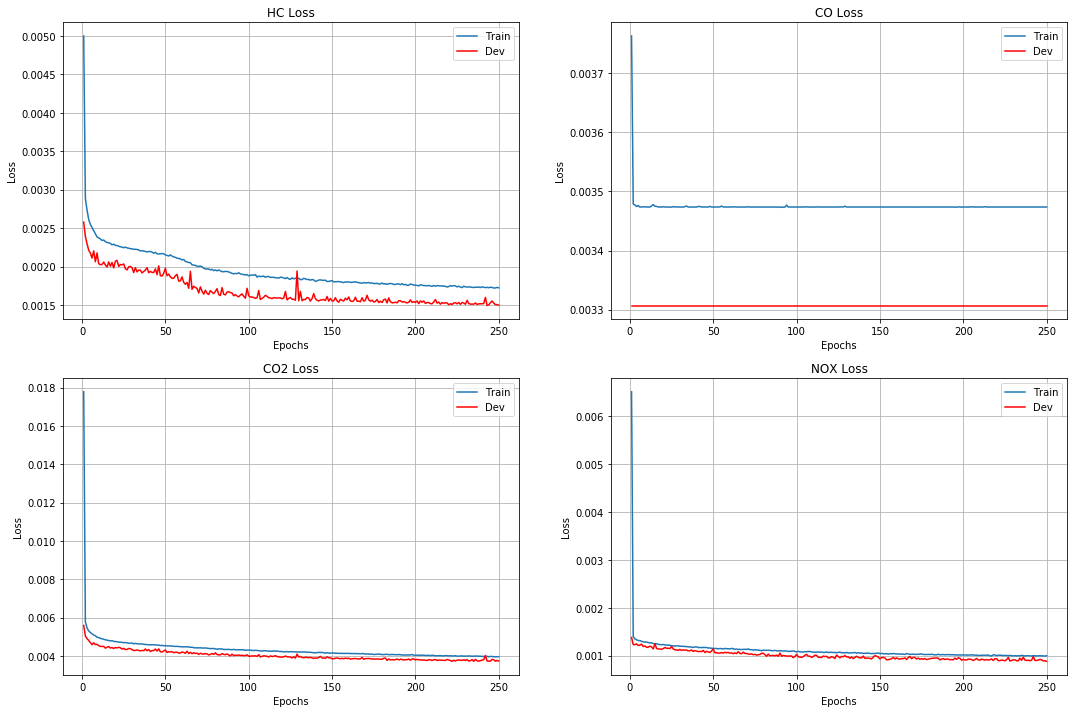

In [56]:
graph_individual_losses(2.1, 'adadelta')

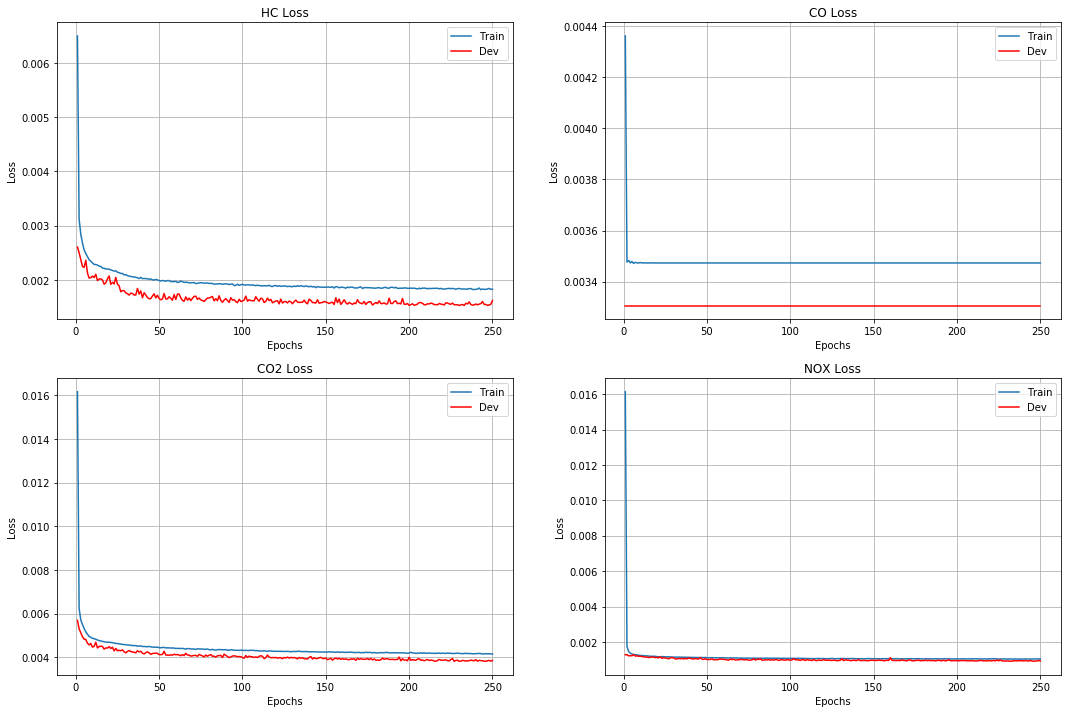

In [57]:
graph_individual_losses(3.0, 'adam')

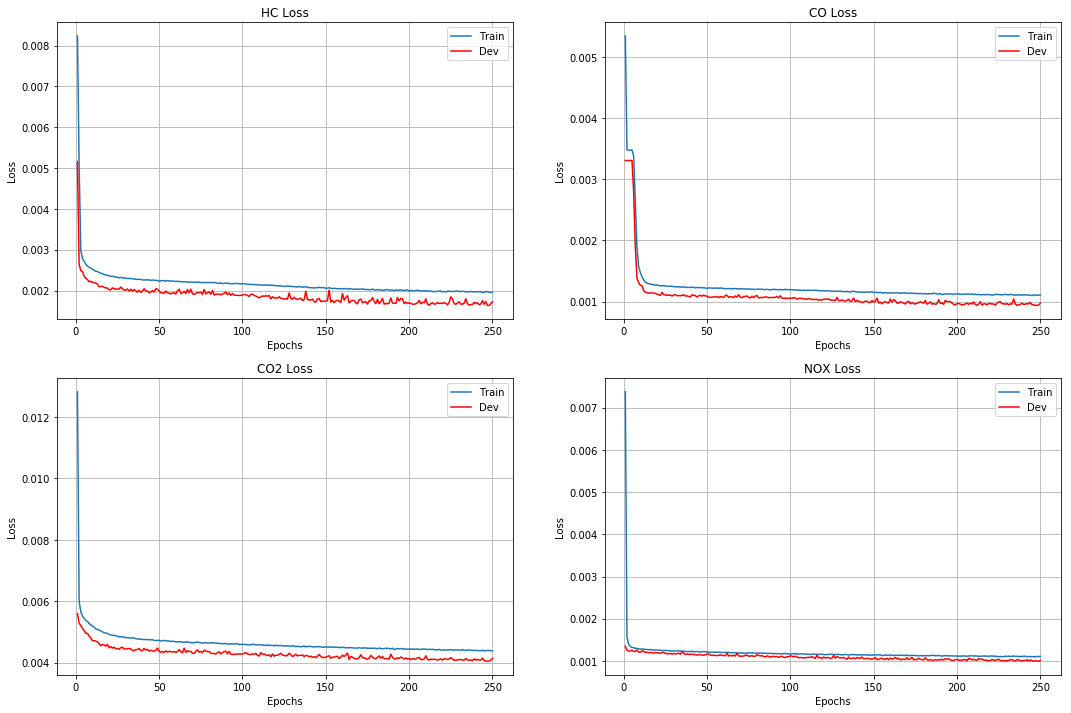

In [58]:
graph_individual_losses(3.1, 'adadelta')

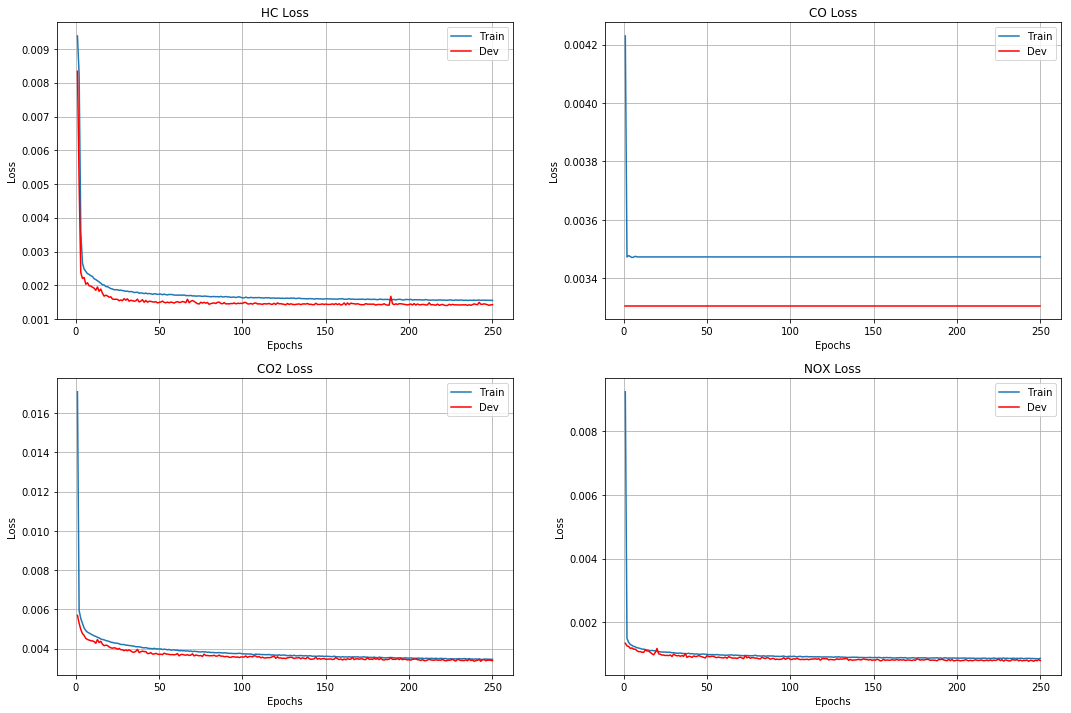

In [59]:
graph_individual_losses(4.0, 'adam')

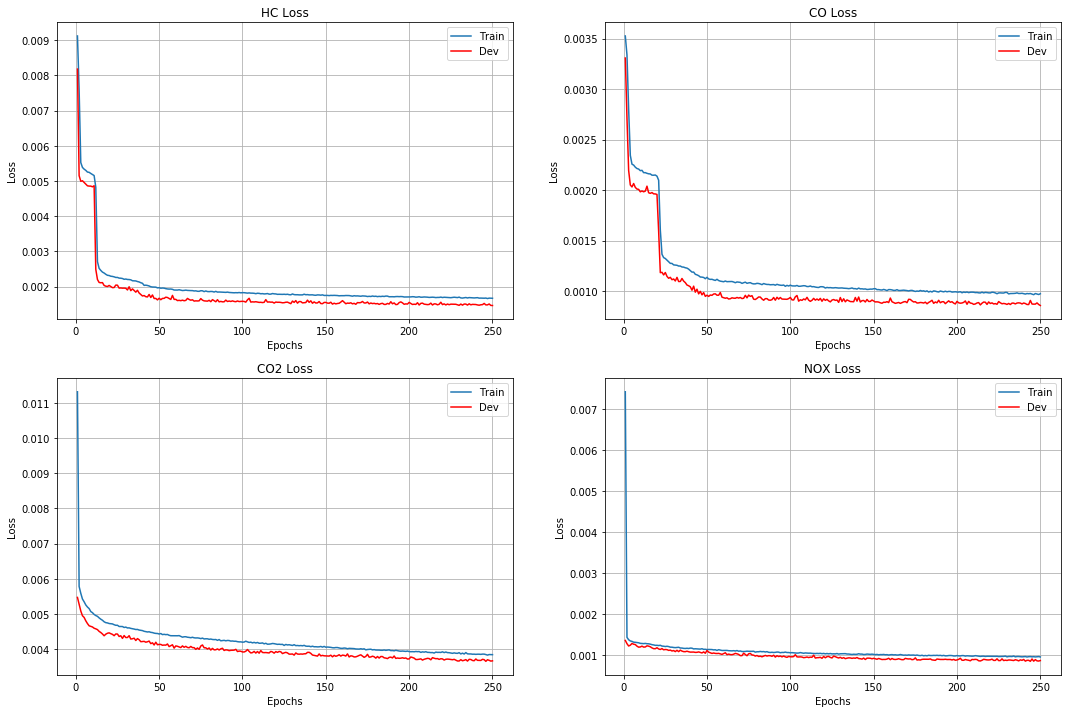

In [60]:
graph_individual_losses(4.1, 'adadelta')

## Evaluating Models

In [61]:
# Function to evaluate models
def evaluate_models(version):
    
    if version == 2.0:
        model = model_v2_adam

    if version == 2.1:
        model = model_v2_adadelta
        
    if version == 3.0:
        model = model_v3_adam
        
    if version == 3.1:
        model = model_v3_adadelta
        
    if version == 4.0:
        model = model_v4_adam
        
    if version == 4.1:
        model = model_v4_adadelta
        
    test_history = model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=1)
    
    return test_history

In [62]:
test_history_v2_adam = evaluate_models(2.0)
test_history_v2_adadelta = evaluate_models(2.1)
test_history_v3_adam = evaluate_models(3.0)
test_history_v3_adadelta = evaluate_models(3.1)
test_history_v4_adam = evaluate_models(4.0)
test_history_v4_adadelta = evaluate_models(4.1)

7814/7814 [==============================] - 0s 47us/step


## Organize Losses Table

In [63]:
# Function to create tables with losses
def table_losses(version):
    
    if version == 2.0:
        model = model_v2_adam
        history = history_v2_adam
        test_history = test_history_v2_adam

    if version == 2.1:
        model = model_v2_adadelta
        history = history_v2_adadelta
        test_history = test_history_v2_adadelta
        
    if version == 3.0:
        model = model_v3_adam
        history = history_v3_adam
        test_history = test_history_v3_adam
        
    if version == 3.1:
        model = model_v3_adadelta
        history = history_v3_adadelta
        test_history = test_history_v3_adadelta
        
    if version == 4.0:
        model = model_v4_adam
        history = history_v4_adam
        test_history = test_history_v4_adam
        
    if version == 4.1:
        model = model_v4_adadelta
        history = history_v4_adadelta
        test_history = test_history_v4_adadelta
    
    # Transpose metrics to get right orientation
    metrics = np.transpose(model.metrics_names[:5])

    # Get losses for the test history
    test_history = test_history[:5]

    # Get losses for the dev history
    dev_history = [history.history["val_loss"][-1], history.history["val_HC_loss"][-1], 
                  history.history["val_CO_loss"][-1], history.history["val_CO2_loss"][-1],
                  history.history["val_NOX_loss"][-1]]

    # Get losses for the training history
    train_history = [history.history["loss"][-1], history.history["HC_loss"][-1], 
                  history.history["CO_loss"][-1], history.history["CO2_loss"][-1],
                  history.history["NOX_loss"][-1]]
    
    # Put everything together into a data frame and get right orientation
    results = pd.DataFrame([metrics, train_history, dev_history, test_history]).transpose()

    # Change column names
    results.columns = ["Metrics", "Training", "Development", "Test"]

    return results

In [64]:
results_v2_adam = table_losses(2.0)
results_v2_adadelta = table_losses(2.1)
results_v3_adam = table_losses(3.0)
results_v3_adadelta = table_losses(3.1)
results_v4_adam = table_losses(4.0)
results_v4_adadelta = table_losses(4.1)

In [65]:
results_v2_adam

,Metrics,Training,Development,Test
0,loss,0.0168371,0.0159878,0.0165938
1,HC_loss,0.00881697,0.00834144,0.00871175
2,CO_loss,0.00347346,0.00330717,0.00341247
3,CO2_loss,0.00362001,0.00350115,0.00357903
4,NOX_loss,0.000926651,0.000838088,0.000890568


In [66]:
results_v2_adadelta

,Metrics,Training,Development,Test
0,loss,0.0101494,0.00941189,0.00977281
1,HC_loss,0.00172273,0.00149643,0.00165368
2,CO_loss,0.00347346,0.00330717,0.00341247
3,CO2_loss,0.00395473,0.00372698,0.00377989
4,NOX_loss,0.000998522,0.000881305,0.000926784


In [67]:
results_v3_adam

,Metrics,Training,Development,Test
0,loss,0.0104949,0.00970784,0.0100233
1,HC_loss,0.00183095,0.00162174,0.00174789
2,CO_loss,0.00347346,0.00330717,0.00341247
3,CO2_loss,0.00414865,0.00385144,0.00389056
4,NOX_loss,0.00104184,0.000927486,0.000972371


In [68]:
results_v3_adadelta

,Metrics,Training,Development,Test
0,loss,0.00855293,0.00784812,0.0081468
1,HC_loss,0.0019568,0.00172401,0.00191659
2,CO_loss,0.00110822,0.000974296,0.00107443
3,CO2_loss,0.00438157,0.00413981,0.00415274
4,NOX_loss,0.00110634,0.00100999,0.00100304


In [69]:
results_v4_adam

,Metrics,Training,Development,Test
0,loss,0.00934703,0.00890966,0.00926085
1,HC_loss,0.00155287,0.00142281,0.00152758
2,CO_loss,0.00347346,0.00330717,0.00341247
3,CO2_loss,0.00344952,0.00337797,0.00344032
4,NOX_loss,0.000871188,0.000801711,0.000880492


In [70]:
results_v4_adadelta

,Metrics,Training,Development,Test
0,loss,0.00745475,0.00686887,0.00715519
1,HC_loss,0.00167163,0.00146576,0.001602
2,CO_loss,0.000974937,0.000858214,0.000932579
3,CO2_loss,0.00384804,0.00367299,0.00371078
4,NOX_loss,0.000960153,0.000871908,0.000909825


## Save Models

In [71]:
# Function to save models
def save_model(version, optimizer):
    
    if version == 2.0:
        model = model_v2_adam

    if version == 2.1:
        model = model_v2_adadelta
        
    if version == 3.0:
        model = model_v3_adam
        
    if version == 3.1:
        model = model_v3_adadelta
        
    if version == 4.0:
        model = model_v4_adam
        
    if version == 4.1:
        model = model_v4_adadelta
        
    model.save("Multi_Task_V{}-{}.h5".format(version,optimizer))

In [72]:
save_model(2.0, 'adam')
save_model(2.1, 'adadelta')
save_model(3.0, 'adam')
save_model(3.1, 'adadelta')
save_model(4.0, 'adam')
save_model(4.1, 'adadelta')

## Save Training History

In [73]:
# Function to graph individual losses according to version
def save_history(version, optimizer):
    
    if version == 2.0:
        history = history_v2_adam

    if version == 2.1:
        history = history_v2_adadelta
        
    if version == 3.0:
        history = history_v3_adam
        
    if version == 3.1:
        history = history_v3_adadelta
        
    if version == 4.0:
        history = history_v4_adam
        
    if version == 4.1:
        history = history_v4_adadelta
        
    #--------------------------------
    
    hist_data = [epoch_vector, history.history['loss'], history.history['val_loss'], history.history['HC_loss'], 
                 history.history['val_HC_loss'], history.history['CO_loss'], history.history['val_CO_loss'], 
                 history.history['CO2_loss'], history.history['val_CO2_loss'], history.history['NOX_loss'], 
                 history.history['val_NOX_loss']]
    
    hist_data = pd.DataFrame(hist_data).transpose()
    
    # Change column names
    hist_data.columns = ['Epochs','loss','val_loss','HC_loss','val_HC_loss','CO_loss','val_CO_loss',
                         'CO2_loss','val_CO2_loss','NOX_loss','val_NOX_loss']
    
    hist_data.to_csv('History_V{}_Data-{}.csv'.format(version, optimizer), encoding='utf-8', index=False)

In [74]:
save_history(2.0, 'adam')
save_history(2.1, 'adadelta')
save_history(3.0, 'adam')
save_history(3.1, 'adadelta')
save_history(4.0, 'adam')
save_history(4.1, 'adadelta')

## Un-scale Values for Comparison

In [92]:
# First, inverse transform all original values from the test_set
test_set_inverse = test_set.copy()

for i in range(np.size(dataset.columns)):
    
    col_name = dataset.columns[i]
    
    values = test_set_inverse[col_name].values
    values = values.astype('float64')
    values = values.reshape(values.shape[0],1)
    
    test_set_inverse[col_name] = scalers[i].inverse_transform(values)
    
    print('Success with feature: {}'.format(col_name))

Success with feature: Year
Success with feature: Vehicle_Code
Success with feature: Manufacturer_Code
Success with feature: Displacement
Success with feature: Fuel_System
Success with feature: Gears
Success with feature: Transmission_Code
Success with feature: ETW
Success with feature: HP
Success with feature: Drive_System_Code
Success with feature: Fuel_Code
Success with feature: V_avg
Success with feature: V_max
Success with feature: V_std
Success with feature: a_pos
Success with feature: a_neg
Success with feature: Peak_pos
Success with feature: Peak_neg
Success with feature: HC
Success with feature: CO
Success with feature: CO2
Success with feature: Nox


## Make Predictions

In [94]:
# Function to make predictions based on model version
def make_predictions(version):
    
    if version == 2.0:
        model = model_v2

    if version == 2.1:
        model = model_v2_linear
        
    if version == 3.0:
        model = model_v3
        
    if version == 3.1:
        model = model_v3_linear
        
    if version == 4.0:
        model = model_v4
    
    if version == 4.1:
        model = model_v4_ReLU
        
    predictions = model.predict(x_test)
    
    return predictions

In [97]:
predictions_v2 = make_predictions(2.0)
predictions_v2_linear = make_predictions(2.1)
predictions_v3 = make_predictions(3.0)
predictions_v3_linear = make_predictions(3.1)
predictions_v4 = make_predictions(4.0)
predictions_v4_ReLU = make_predictions(4.1)

In [111]:
predicted_HC_prueba = scalers[-4].inverse_transform(predictions_v2[0])

In [120]:
prueba_diff = []
for i in range(x_test.shape[0]):
    
    original = test_set_inverse['HC'][i]
 
    diff = 100*(np.absolute(predicted_HC_prueba[i]-original)/original)
        
    prueba_diff.append(diff)

In [123]:
np.max(prueba_diff)

273237.12

In [131]:
test_set_inverse['HC'][7804]

0.00046602825

In [134]:
predicted_HC_prueba[7804]

array([0.00728479], dtype=float32)

In [124]:
prueba = pd.DataFrame(prueba_diff)

In [130]:
prueba

,0
0,45.914795
1,5.171916
2,36.735420
3,25.198734
4,14.308132
5,63.434868
6,191.315109
7,28.677773
8,421.243011
9,1074.740723


In [129]:
prueba[prueba[0]==273237.12]

,0


In [159]:
modelo_prueba = load_model('Multi_Task_V4.0-No_Zeros.h5')

In [161]:
prueba_historia = modelo_prueba.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=1)

7814/7814 [==============================] - 0s 56us/step


In [162]:
prueba_historia[:5]

[0.010466667328393152,
 0.0021211319191952,
 0.001155982857961818,
 0.005616848431841075,
 0.0015727041281552593]

In [ ]:
# Function to reverse the scaling based on the model version
def inverse_scale(version):
    
    if version == 2.0:
        predictions = predictions_v2

    if version == 2.1:
        predictions = predictions_v2_linear
        
    if version == 3.0:
        predictions = predictions_v3
        
    if version == 3.1:
        predictions = predictions_v3_linear
        
    if version == 4.0:
        predictions = predictions_v4
        
    if version == 4.1:
        predictions = predictions_v4_ReLU
        
    # Divide the predictions into each emissions category
    

In [98]:
for i in range(n_out):
    print(i)

0
1
2
3
